# Import

 Bayesian “Change point analysis”

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

### Bayesian switchpoint analysis

https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis

Text(0.5, 1.0, 'Mining disaster data set')

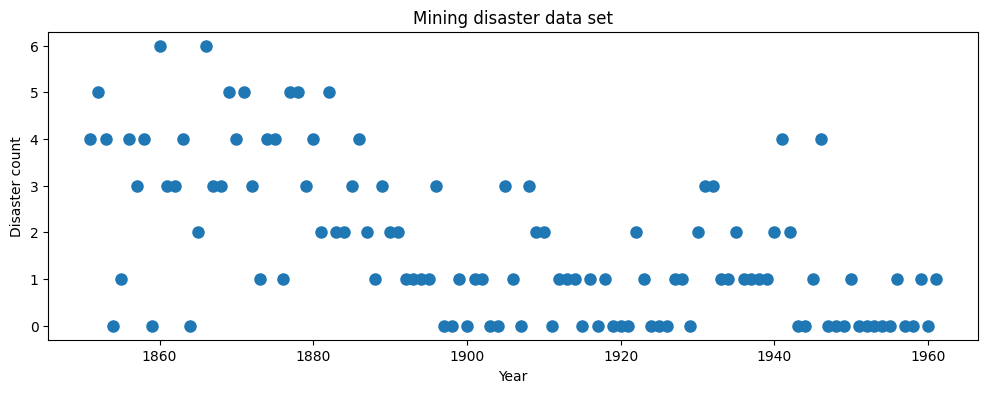

In [ ]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
ax.plot(years, disaster_data, 'o', markersize=8);
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year')
ax.set_title('Mining disaster data set')

# Probablistic Model

The model assumes a “switch point” (e.g. a year during which safety regulations changed), and Poisson-distributed disaster rate with constant (but potentially different) rates before and after that switch point.

The actual disaster count is fixed (observed); any sample of this model will need to specify both the switchpoint and the “early” and “late” rate of disasters.

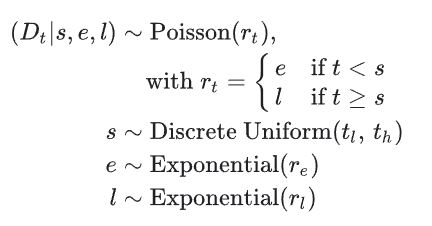

However, the mean disaster rate 
 has a discontinuity at the switchpoint 
, which makes it not differentiable. Thus it provides no gradient signal to the Hamiltonian Monte Carlo (HMC) algorithm – but because the 
 prior is continuous, HMC’s fallback to a random walk is good enough to find the areas of high probability mass in this example.

As a second model, we modify the original model using a sigmoid “switch” between e and l to make the transition differentiable, and use a continuous uniform distribution for the switchpoint 
. (One could argue this model is more true to reality, as a “switch” in mean rate would likely be stretched out over multiple years.) The new model is thus:

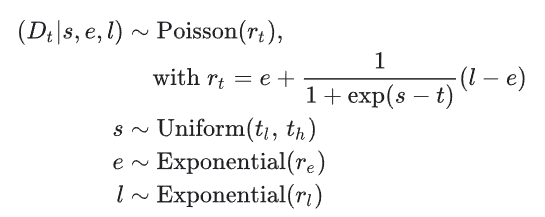

In [ ]:
tf_min_year = tf.cast(tf.reduce_min(years), dtype=tf.float32)
tf_max_year = tf.cast(tf.reduce_max(years), dtype=tf.float32)

def disaster_count_model_switch():
    """Return a probabalistic model for distaster count data.
    Early and late exponentially-distributed variables parameterize
    the Poisson before and after the switchpoint. The Switchpoint is
    uniformly distributed.
    """
    disaster_count = tfd.JointDistributionNamed(
        dict(
            early_rate=tfd.Exponential(rate=1.),
            late_rate=tfd.Exponential(rate=1.),
            switchpoint=tfd.Uniform(low=tf_min_year, high=tf_max_year),
            d_t=lambda switchpoint, late_rate, early_rate: tfd.Independent(
                tfd.Poisson(rate=tf.where(years < switchpoint, early_rate, late_rate),
                    force_probs_to_zero_outside_support=True
                ),
                reinterpreted_batch_ndims=1
            )
        )
    )
    return disaster_count

def disaster_count_model_sigmoid():
    """Return a probabalistic model for distaster count data.
    Early and late exponentially-distributed variables parameterize
    the Poisson before and after the switchpoint. The Switchpoint is
    uniformly distributed.
    """
    disaster_count = tfd.JointDistributionNamed(
        dict(
            early_rate=tfd.Exponential(rate=1.),
            late_rate=tfd.Exponential(rate=1.),
            switchpoint=tfd.Uniform(low=tf_min_year, high=tf_max_year),
            d_t=lambda switchpoint, late_rate, early_rate: tfd.Independent(
                tfd.Poisson(rate= early_rate + tf.sigmoid(years - switchpoint)*(late_rate - early_rate),
                    force_probs_to_zero_outside_support=True ),
                reinterpreted_batch_ndims=1
            )
        )
    )
    return disaster_count

model_switch = disaster_count_model_switch()
model_sigmoid = disaster_count_model_sigmoid()

Sanity-check that the target log prob function is sane

In [ ]:
def target_log_prob_fn(model, switchpoint, early_rate, late_rate):
  """Return log probability of the data relative to the input parameters."""
  return model.log_prob(
    switchpoint=switchpoint,
    early_rate=early_rate,
    late_rate=late_rate,
    d_t=disaster_data
  )

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 1880., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 1855., 1., .5).numpy() for m in models])  # Very unlikely result
print([target_log_prob_fn(m, -10., 1., .1).numpy() for m in models])  # Impossible result

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


[-189.95573, -186.61452]
[-301.88947, -300.6136]
[-inf, -inf]


# MCMC approach

## HMC to do Bayesian inference

In [ ]:
num_burnin_steps = 3000
num_results = 10000
years_midpoint = (tf_max_year + tf_min_year) / 2.

@tf.function(autograph=False, jit_compile=True)
def make_chain(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.05,
            num_leapfrog_steps=3),
        bijector=[
            # The bijectors are arranged in the same order as the inputs
            # to the log_prob_fn.
            # The switchpoint is constrained between the start and end years.
            # Hence we supply a bijector that maps the real numbers (in a
            # differentiable way) to the interval (min_year;max_year)
            tfb.Sigmoid(low=tf_min_year, high=tf_max_year),
            # Early and late disaster rates are mapped to the positive real numbers
            tfb.Softplus(),
            tfb.Softplus()
        ]
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps)
    )
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            # Starting values for the three latent variables
            tf.ones([], name='init_switchpoint')*(tf_max_year+tf_min_year)/2,
            tf.ones([], name='init_early_rate'),
            tf.ones([], name='init_late_rate'),
        ],
        trace_fn=None,
        kernel=kernel
    )
    return states



# Provide model to log_prob_fn and pass through sampled variables
switch_samples_hmc = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples_hmc = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]


print(switch_samples_hmc)
print(sigmoid_samples_hmc)

[array([1892.0045, 1889.2213, 1890.2695, ..., 1891.168 , 1891.561 ,
       1891.4972], dtype=float32), array([3.0956078, 3.2060583, 3.119487 , ..., 3.295446 , 3.200244 ,
       3.2258232], dtype=float32), array([0.99958324, 0.9068821 , 0.9333178 , ..., 0.9480848 , 0.9876193 ,
       0.9828427 ], dtype=float32)]
[array([1891.5892, 1891.5892, 1891.5892, ..., 1890.3617, 1889.3485,
       1889.8872], dtype=float32), array([3.0631776, 3.0631776, 3.0631776, ..., 3.2592177, 3.210661 ,
       3.9670694], dtype=float32), array([0.7642609 , 0.7642609 , 0.7642609 , ..., 0.73516035, 0.91673476,
       0.9497279 ], dtype=float32)]


## NUTS Algorithm

In [ ]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, jit_compile=True)
def make_chain_nuts(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.05),
         bijector=[
            # The bijectors are arranged in the same order as the inputs
            # to the log_prob_fn.
            # The switchpoint is constrained between the start and end years.
            # Hence we supply a bijector that maps the real numbers (in a
            # differentiable way) to the interval (min_year;max_year)
            tfb.Sigmoid(low=tf_min_year, high=tf_max_year),
            # Early and late disaster rates are mapped to the positive real numbers
            tfb.Softplus(),
            tfb.Softplus()
        ]
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps)
    )
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            # Starting values for the three latent variables
            tf.ones([], name='init_switchpoint')*(tf_max_year+tf_min_year)/2,
            tf.ones([], name='init_early_rate'),
            tf.ones([], name='init_late_rate'),
        ],
        trace_fn=None,
        kernel=kernel
    )
    return states
switch_samples_nuts = [s.numpy() for s in make_chain_nuts(
    lambda *args: target_log_prob_fn(model_switch, *args))]

sigmoid_samples_nuts = [s.numpy() for s in make_chain_nuts(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]


print(switch_samples_nuts)

print(sigmoid_samples_nuts)

[array([1897.7692, 1897.4113, 1896.9843, ..., 1891.0249, 1889.6235,
       1890.3335], dtype=float32), array([3.2906358, 3.2580142, 3.4213097, ..., 3.138493 , 2.837931 ,
       2.8170822], dtype=float32), array([0.7957592 , 0.79999024, 0.9660739 , ..., 1.0764965 , 1.0198791 ,
       1.0158676 ], dtype=float32)]
[array([1889.526 , 1888.2861, 1888.2861, ..., 1890.5328, 1891.0604,
       1890.0597], dtype=float32), array([2.8872612, 3.2622895, 3.2622895, ..., 2.920888 , 3.1296332,
       3.4120162], dtype=float32), array([0.8928476 , 0.8056665 , 0.8056665 , ..., 0.99438727, 0.8298682 ,
       0.89520216], dtype=float32)]


## RWS Algorithm

In [ ]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, jit_compile=True)
def make_chain_rws(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=target_log_prob_fn,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1),
        ),
        bijector=[
            tfb.Sigmoid(low=tf_min_year, high=tf_max_year),
            tfb.Softplus(),
            tfb.Softplus(),
        ]
    )

    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            tf.ones([], name='init_switchpoint')*(tf_max_year+tf_min_year)/2,
            tf.ones([], name='init_early_disaster_rate'),
            tf.ones([], name='init_late_disaster_rate'),
        ],
        trace_fn=None,
        kernel=kernel,
    )

    return states

switch_samples_rwm = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples_rwm = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]


print(switch_samples_rwm)


[array([1891.9581, 1891.9581, 1893.1432, ..., 1889.5531, 1890.2648,
       1889.5461], dtype=float32), array([2.7803352, 2.7803352, 2.8829463, ..., 3.1729693, 3.2950058,
       3.333134 ], dtype=float32), array([0.6519472, 0.6519472, 0.7160754, ..., 1.0863545, 1.1440852,
       1.020743 ], dtype=float32)]


# Visualize the result

This code will create a series of plots for each algorithm, showing the posterior distributions and trace plots for the switchpoint, early disaster rate, and late disaster rate.

## Analysis 1

In [ ]:
def plot_rate_switch(switch_point_samples, early_rate_samples, late_rate_samples ,name):
    rates = np.ones(years.shape) * np.mean(early_rate_samples)
    rates[years >= np.mean(switch_point_samples)] = np.mean(late_rate_samples)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
    ax.plot(years, disaster_data, 'o', markersize=8);
    ax.plot(years, rates, linewidth=3)
    ax.set_ylabel('Disaster count')
    ax.set_xlabel('Year')
    ax.set_title(f'Mining disaster data set using Sampling Technique {name} having sigmoid Model')
    plt.show()

[array([1891.5892, 1891.5892, 1891.5892, ..., 1890.3617, 1889.3485,
       1889.8872], dtype=float32), array([3.0631776, 3.0631776, 3.0631776, ..., 3.2592177, 3.210661 ,
       3.9670694], dtype=float32), array([0.7642609 , 0.7642609 , 0.7642609 , ..., 0.73516035, 0.91673476,
       0.9497279 ], dtype=float32)]


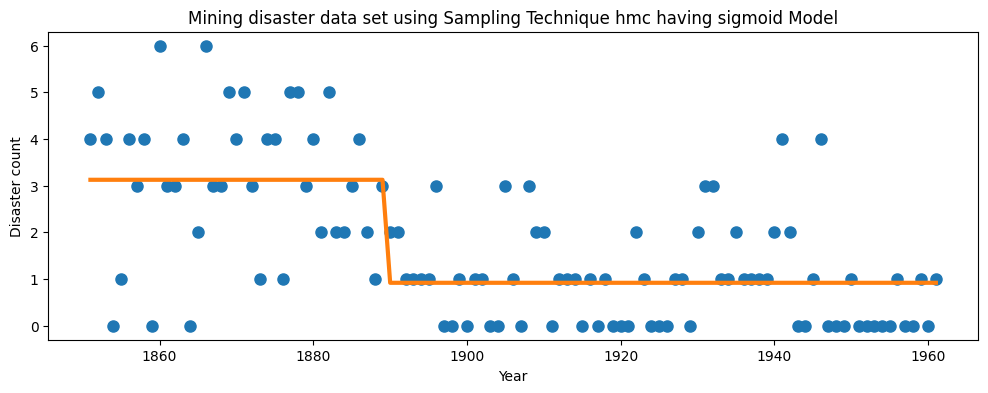

[array([1889.526 , 1888.2861, 1888.2861, ..., 1890.5328, 1891.0604,
       1890.0597], dtype=float32), array([2.8872612, 3.2622895, 3.2622895, ..., 2.920888 , 3.1296332,
       3.4120162], dtype=float32), array([0.8928476 , 0.8056665 , 0.8056665 , ..., 0.99438727, 0.8298682 ,
       0.89520216], dtype=float32)]


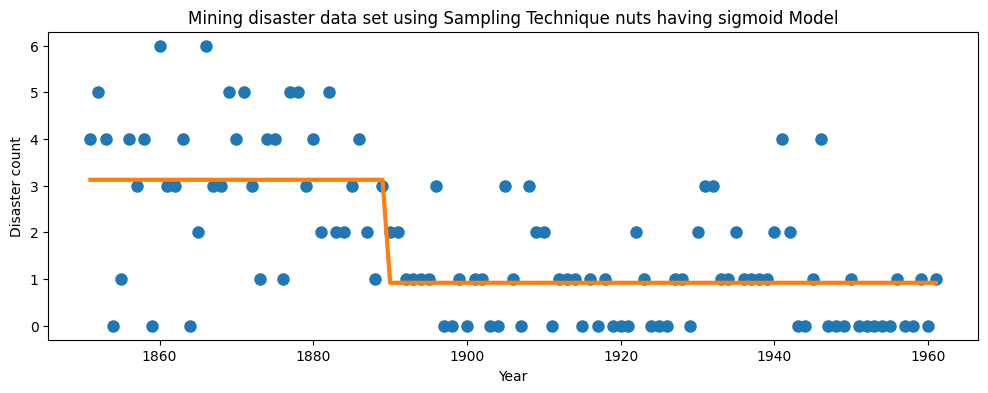

[array([1890.4705, 1890.4705, 1889.2234, ..., 1888.8029, 1891.8859,
       1892.9294], dtype=float32), array([3.441915 , 3.441915 , 3.0625505, ..., 3.0004637, 3.210795 ,
       3.084436 ], dtype=float32), array([0.8438075 , 0.8438075 , 0.9764686 , ..., 0.8509574 , 0.9124891 ,
       0.76646644], dtype=float32)]


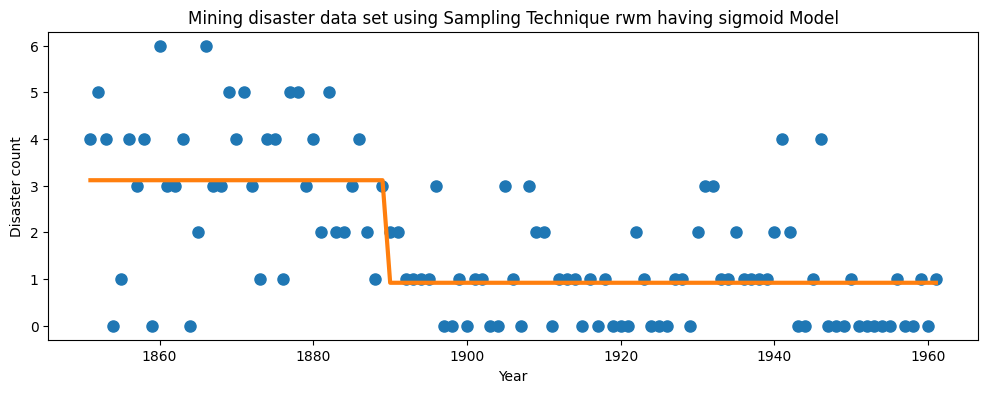

In [ ]:
names = ['hmc','nuts','rwm']
for i in names:
  method = globals()[f'sigmoid_samples_{i}']
  print(method)
  plot_rate_switch(method[0], method[1], method[2],i)

[array([1892.0045, 1889.2213, 1890.2695, ..., 1891.168 , 1891.561 ,
       1891.4972], dtype=float32), array([3.0956078, 3.2060583, 3.119487 , ..., 3.295446 , 3.200244 ,
       3.2258232], dtype=float32), array([0.99958324, 0.9068821 , 0.9333178 , ..., 0.9480848 , 0.9876193 ,
       0.9828427 ], dtype=float32)]


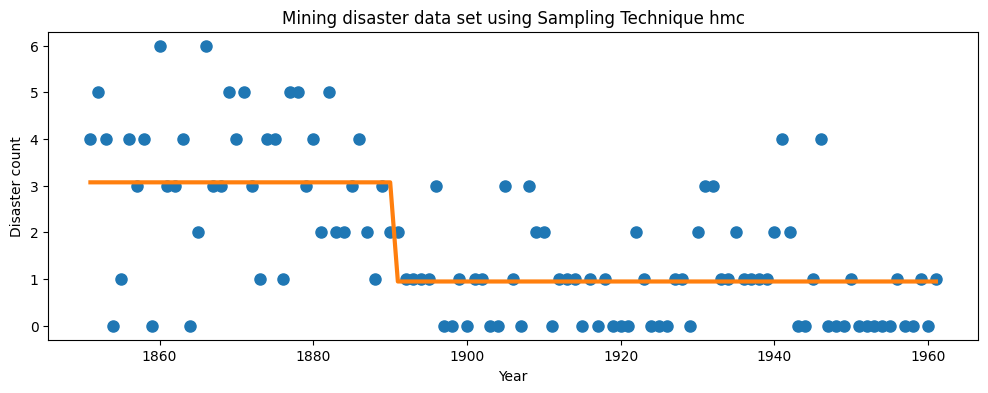

[array([1897.7692, 1897.4113, 1896.9843, ..., 1891.0249, 1889.6235,
       1890.3335], dtype=float32), array([3.2906358, 3.2580142, 3.4213097, ..., 3.138493 , 2.837931 ,
       2.8170822], dtype=float32), array([0.7957592 , 0.79999024, 0.9660739 , ..., 1.0764965 , 1.0198791 ,
       1.0158676 ], dtype=float32)]


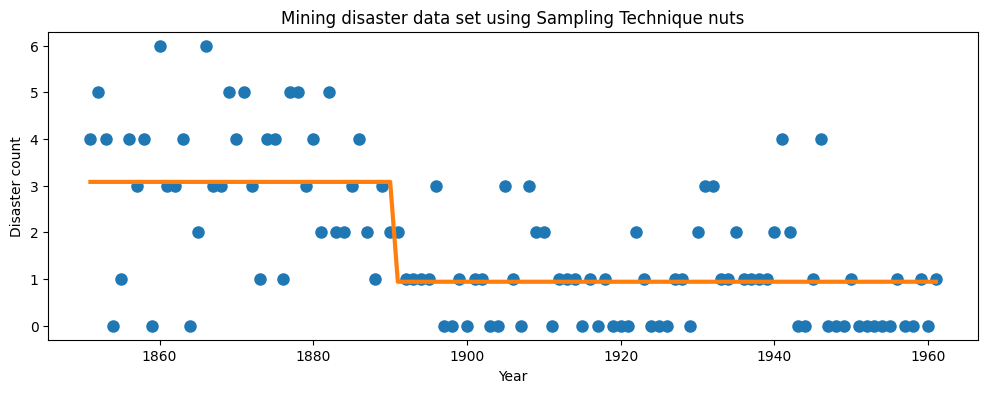

[array([1891.9581, 1891.9581, 1893.1432, ..., 1889.5531, 1890.2648,
       1889.5461], dtype=float32), array([2.7803352, 2.7803352, 2.8829463, ..., 3.1729693, 3.2950058,
       3.333134 ], dtype=float32), array([0.6519472, 0.6519472, 0.7160754, ..., 1.0863545, 1.1440852,
       1.020743 ], dtype=float32)]


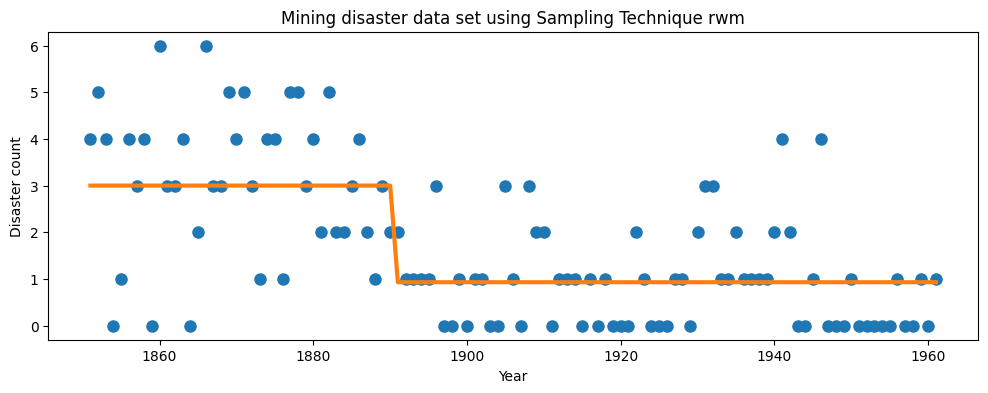

In [ ]:
names = ['hmc','nuts','rwm']
for i in names:
  method = globals()[f'switch_samples_{i}']
  print(method)
  plot_rate_switch(method[0], method[1], method[2],i)

## Analysis **2**

To compare the performance of the HMC, NUTS, and RWM algorithms
1. Trace plots: These plots show the sampled values of each parameter against the iteration number. They help us visually assess the mixing and convergence of the chains.


3. Effective sample size (ESS): ESS is a measure of the number of independent samples generated by the MCMC algorithm. It accounts for the correlation between samples, and higher ESS values indicate better sampling efficiency.


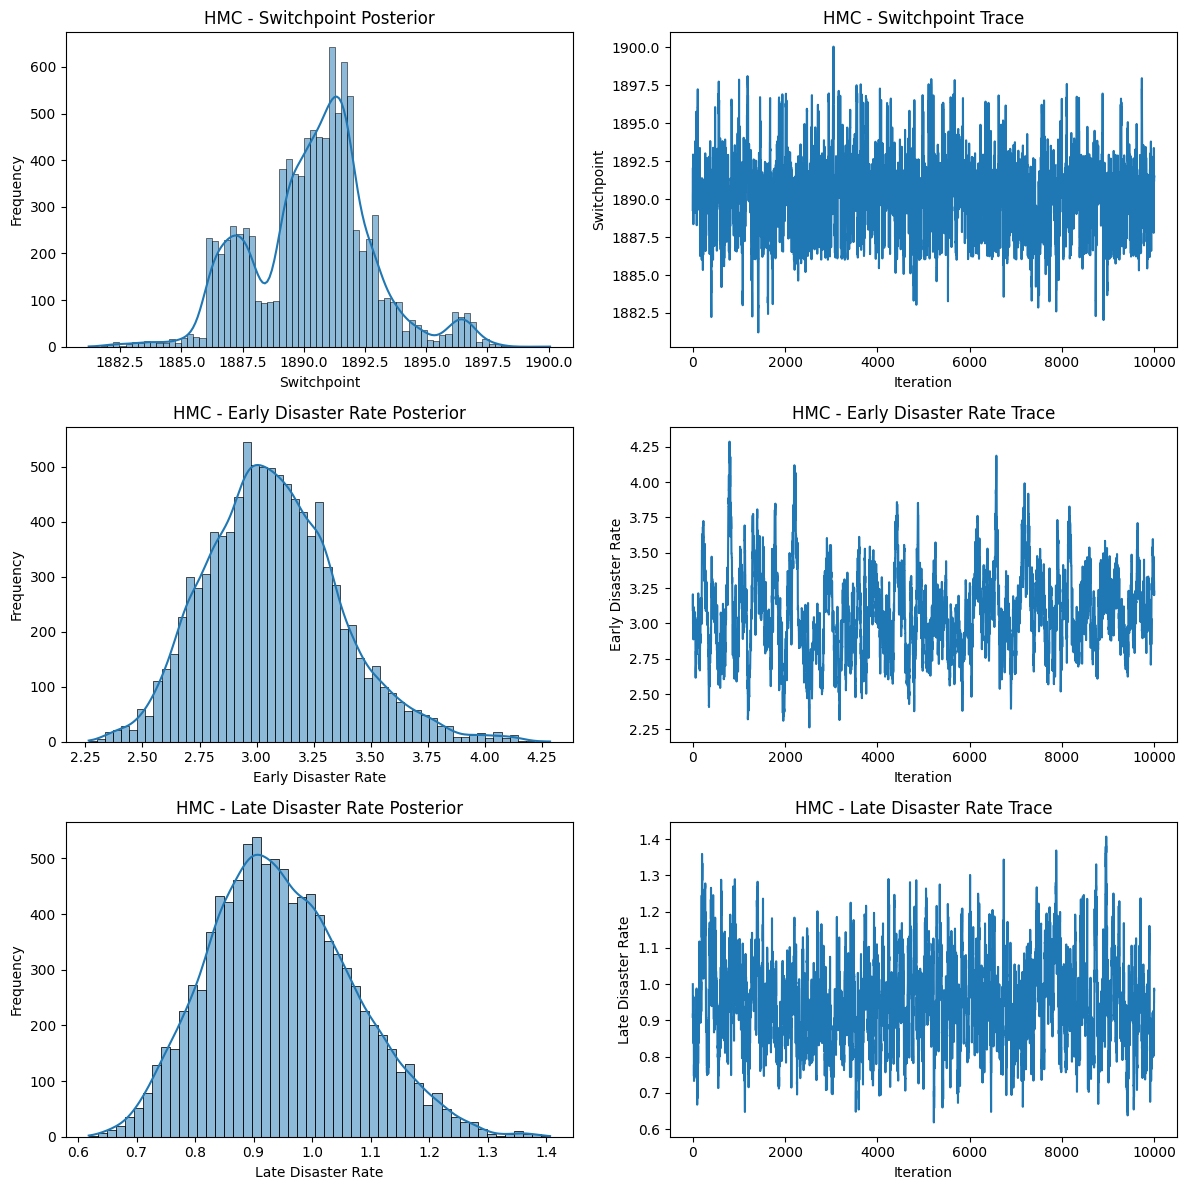

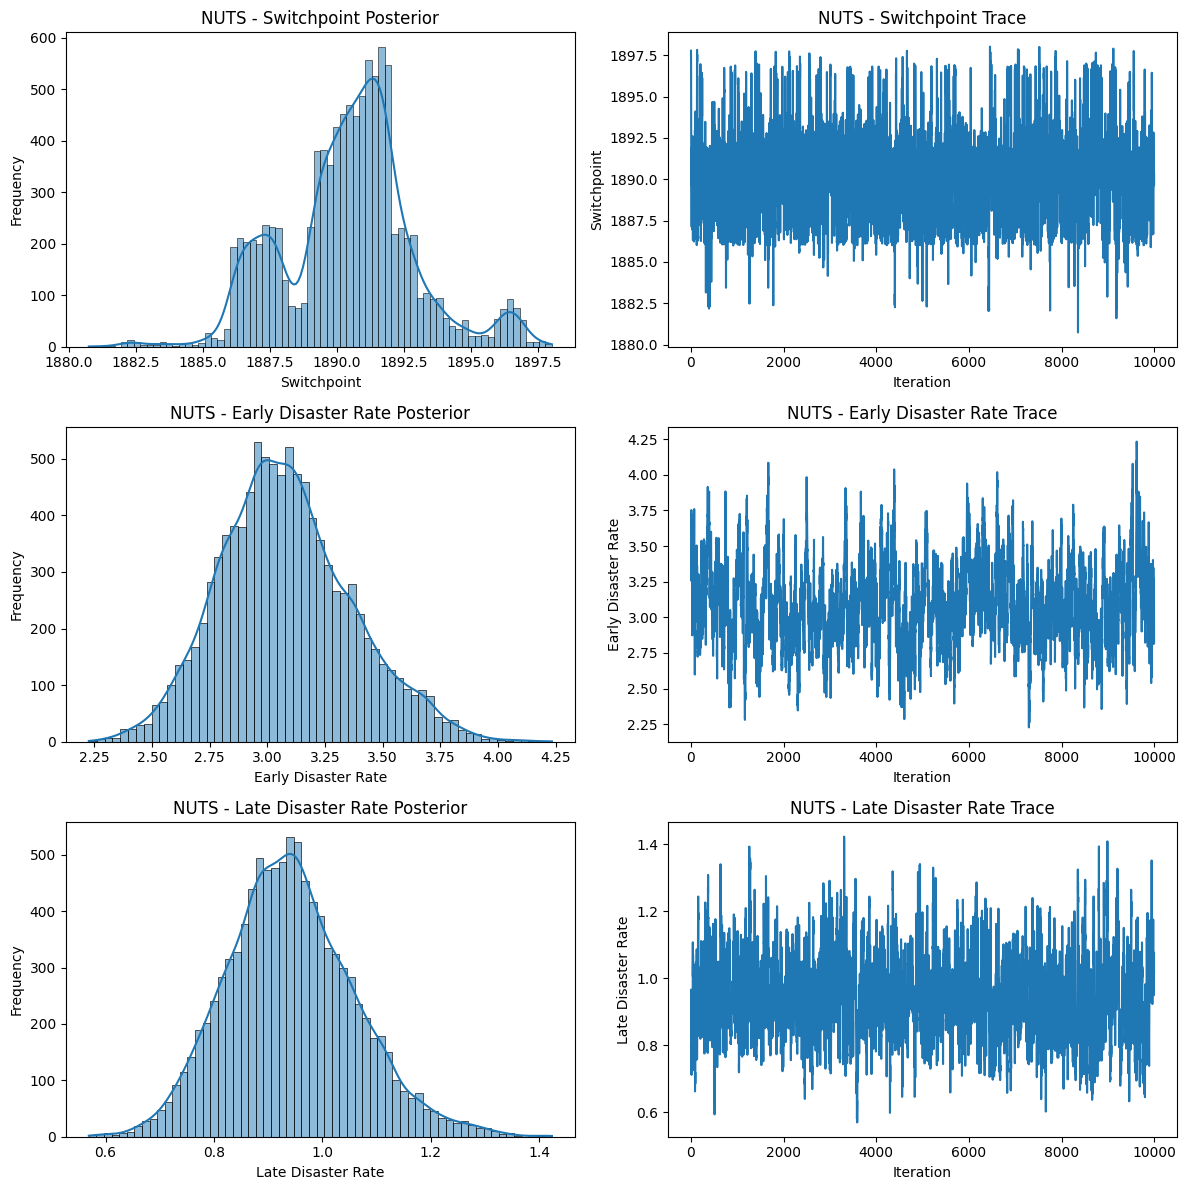

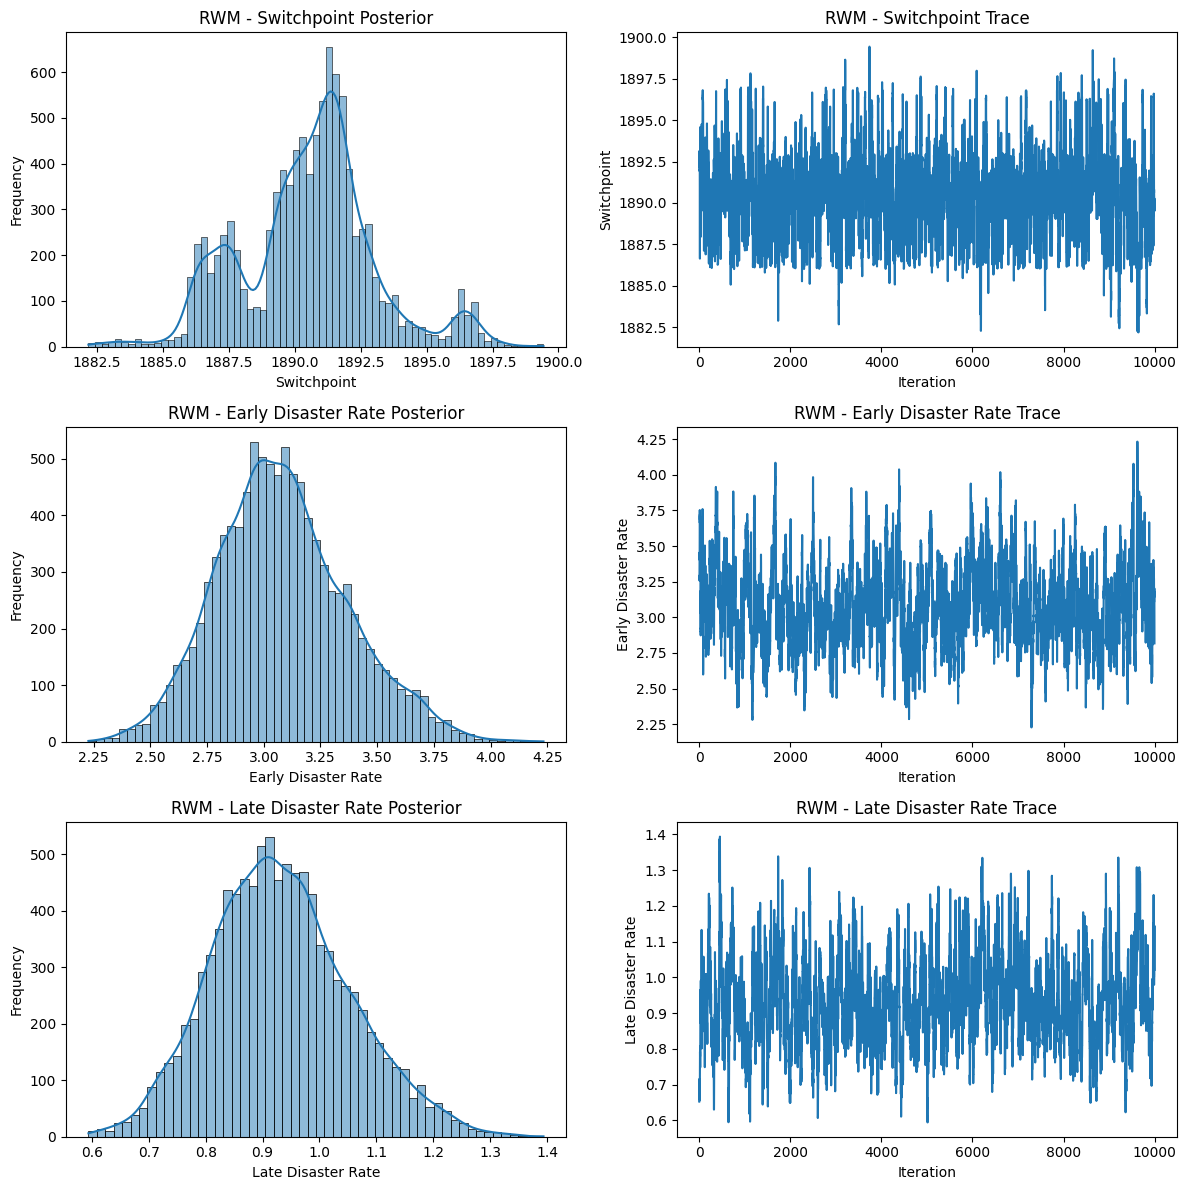

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_posterior(samples, title, parameter_name, ax):
    sns.histplot(samples, kde=True, ax=ax)
    ax.set_title(f"{title} - {parameter_name} Posterior")
    ax.set_xlabel(parameter_name)
    ax.set_ylabel("Frequency")

def plot_trace(samples, title, parameter_name, ax):
    ax.plot(samples)
    ax.set_title(f"{title} - {parameter_name} Trace")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(parameter_name)

def plot_algorithm_comparison(switch_samples, early_samples, late_samples, algorithm_name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    
    plot_posterior(switch_samples, algorithm_name, "Switchpoint", axes[0, 0])
    plot_trace(switch_samples, algorithm_name, "Switchpoint", axes[0, 1])
    
    plot_posterior(early_samples, algorithm_name, "Early Disaster Rate", axes[1, 0])
    plot_trace(early_samples, algorithm_name, "Early Disaster Rate", axes[1, 1])
    
    plot_posterior(late_samples, algorithm_name, "Late Disaster Rate", axes[2, 0])
    plot_trace(late_samples, algorithm_name, "Late Disaster Rate", axes[2, 1])

    plt.tight_layout()
    plt.show()

plot_algorithm_comparison(switch_samples_hmc[0], switch_samples_hmc[1], switch_samples_hmc[2], "HMC")
plot_algorithm_comparison(switch_samples_nuts[0], switch_samples_nuts[1], switch_samples_nuts[2], "NUTS")
plot_algorithm_comparison(switch_samples_rwm[0], switch_samples_nuts[1], switch_samples_rwm[2], "RWM")


In [ ]:
def compute_ess(switch_samples, early_samples, late_samples):
    ess_switch = tfp.mcmc.effective_sample_size(tf.convert_to_tensor(switch_samples)).numpy()
    ess_early = tfp.mcmc.effective_sample_size(tf.convert_to_tensor(early_samples)).numpy()
    ess_late = tfp.mcmc.effective_sample_size(tf.convert_to_tensor(late_samples)).numpy()
    return ess_switch, ess_early, ess_late

ess_hmc = compute_ess(switch_samples_hmc[0], switch_samples_hmc[1], switch_samples_hmc[2])
ess_nuts = compute_ess(switch_samples_nuts[0], switch_samples_nuts[1], switch_samples_nuts[2])
ess_rwm = compute_ess(switch_samples_rwm[0], switch_samples_nuts[1], switch_samples_rwm[2])

print("Effective Sample Size (ESS):")
print(f"HMC: Switchpoint: {ess_hmc[0]}, Early Disaster Rate: {ess_hmc[1]}, Late Disaster Rate: {ess_hmc[2]}")
print(f"NUTS: Switchpoint: {ess_nuts[0]}, Early Disaster Rate: {ess_nuts[1]}, Late Disaster Rate: {ess_nuts[2]}")
print(f"RWM: Switchpoint: {ess_rwm[0]}, Early Disaster Rate: {ess_rwm[1]}, Late Disaster Rate: {ess_rwm[2]}")



Effective Sample Size (ESS):
HMC: Switchpoint: 621.0594482421875, Early Disaster Rate: 142.54629516601562, Late Disaster Rate: 324.51934814453125
NUTS: Switchpoint: 905.6096801757812, Early Disaster Rate: 223.01910400390625, Late Disaster Rate: 644.7360229492188
RWM: Switchpoint: 488.238525390625, Early Disaster Rate: 223.01910400390625, Late Disaster Rate: 279.3550109863281


## Analysis 3
We visualize the result as histograms of samples of the posterior distribution for the early and late disaster rate, as well as the switchpoint. The histograms are overlaid with a solid line representing the sample median, as well as the 95%ile credible interval bounds as dashed lines.

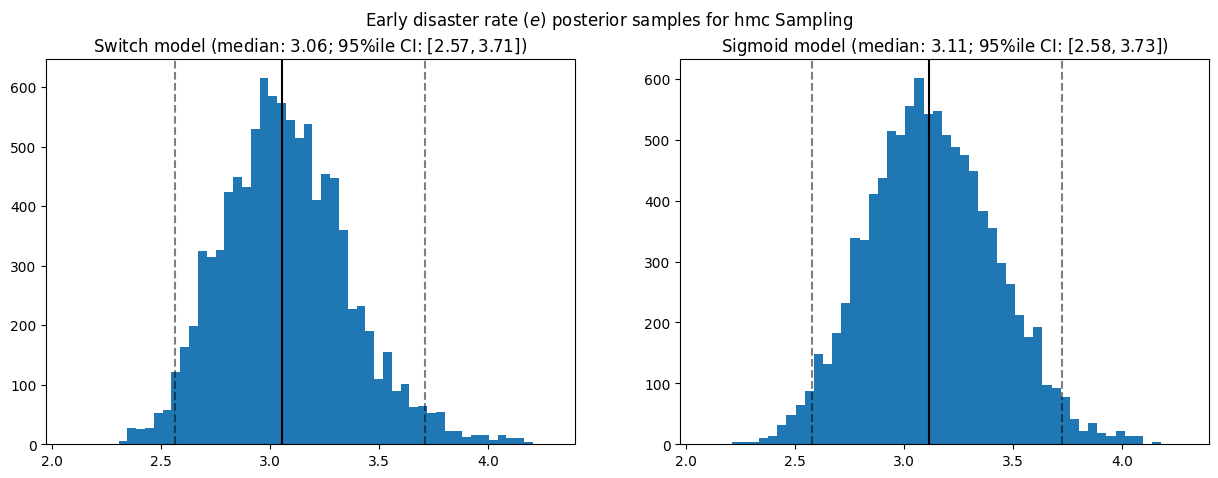

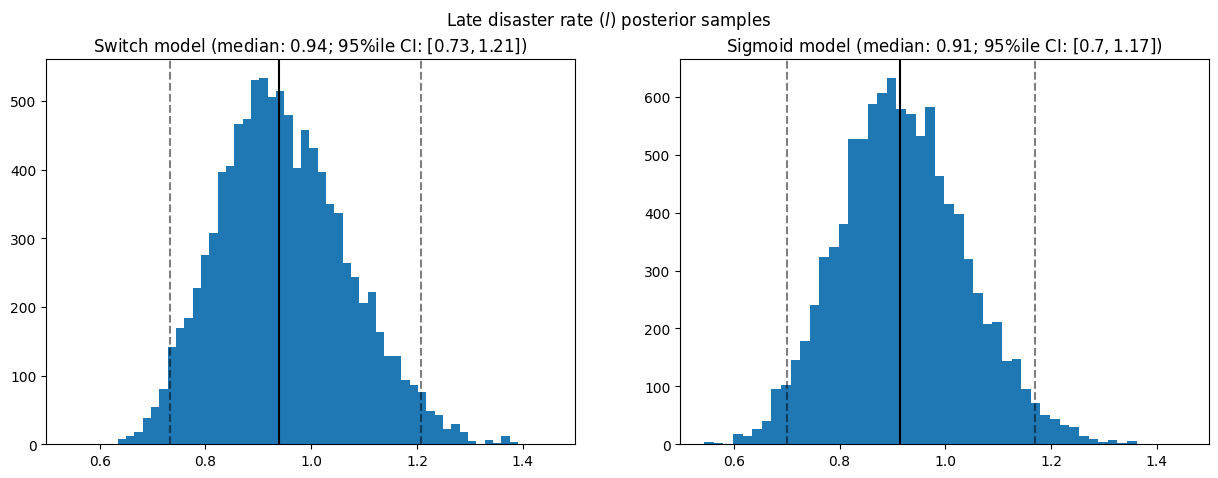

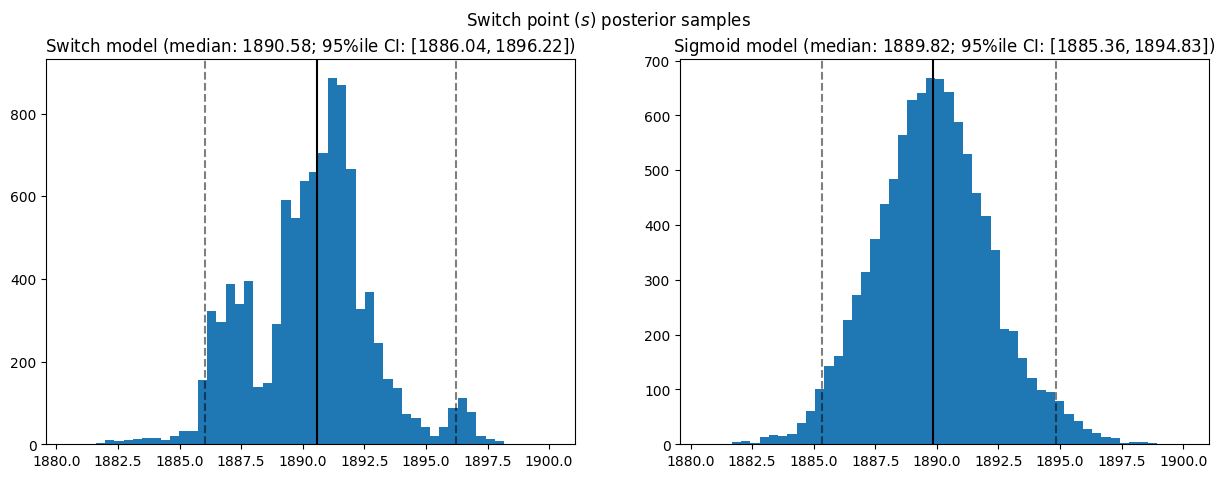

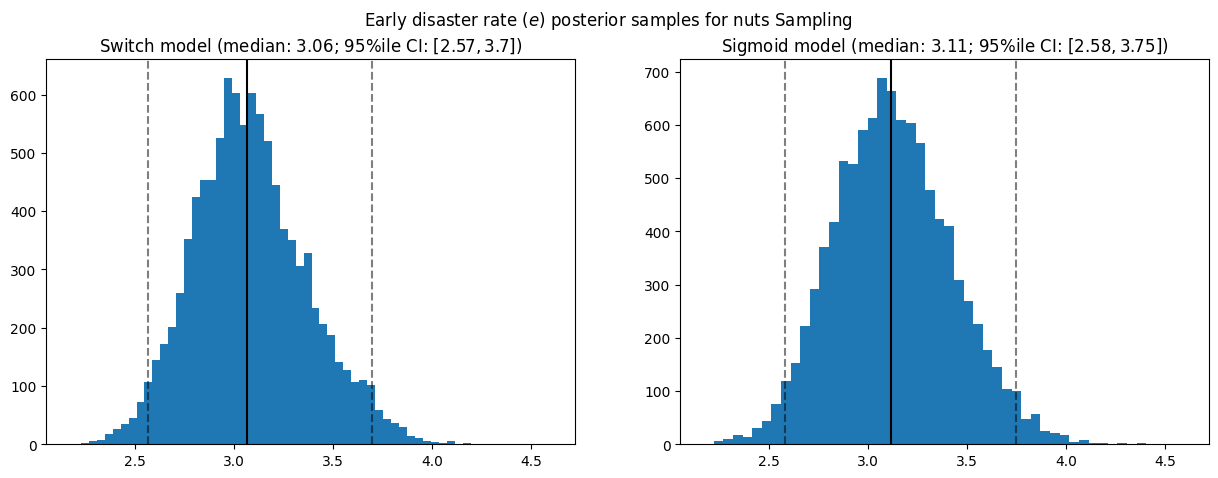

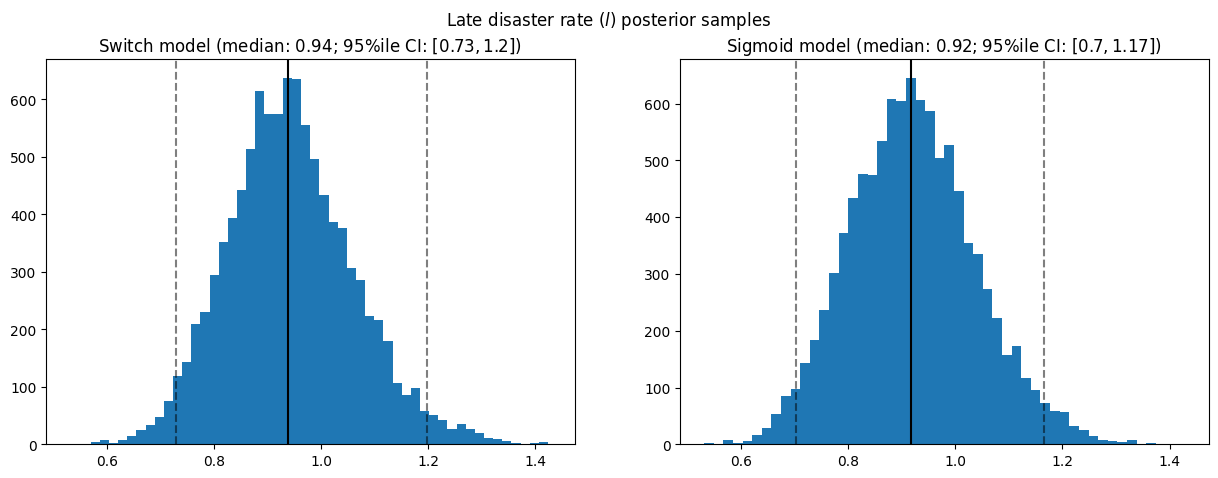

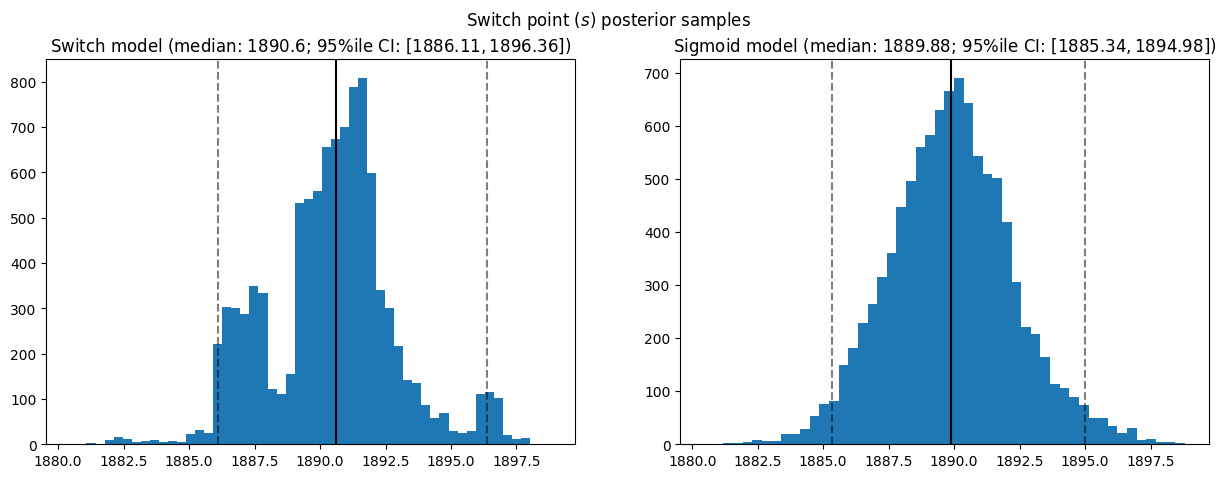

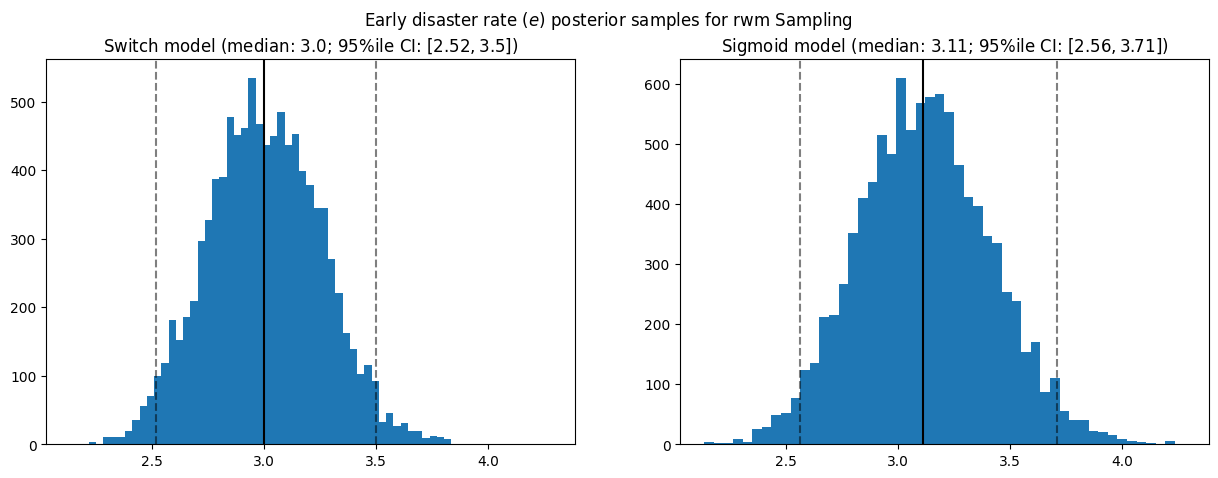

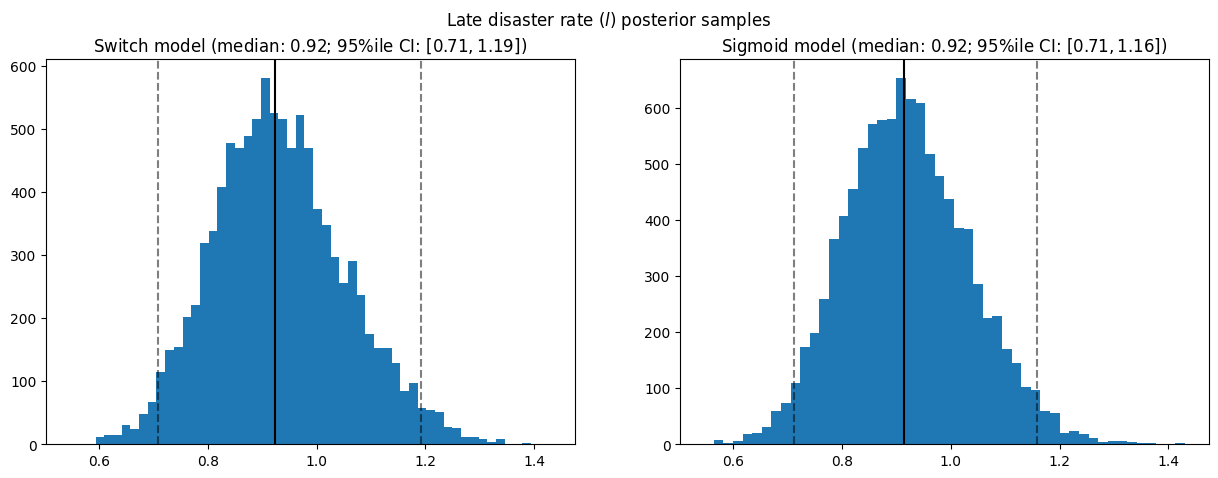

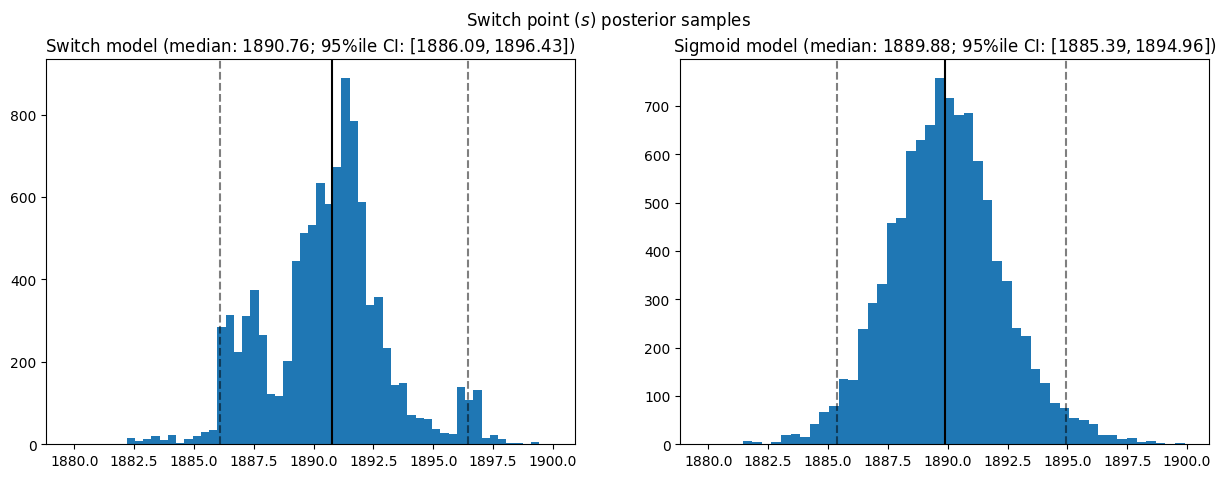

In [ ]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

def plots_analysis3(name):
  method1 = globals()[f'switch_samples_{name}']
  method2 = globals()[f'sigmoid_samples_{name}']
  switchpoint, early_disaster_rate, late_disaster_rate = zip(
      method1, method2)

  for t, v in [
      (f'Early disaster rate ($e$) posterior samples for {name} Sampling', early_disaster_rate),
      ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
      ('Switch point ($s$) posterior samples',switchpoint),
  ]:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(15, 5))
    for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
      a = ax[i]
      a.hist(v[i], bins=50)
      a.axvline(x=np.percentile(v[i], 50), color='k')
      a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
      a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
      a.set_title(m + ' model ' + _desc(v[i]))
    fig.suptitle(t)
    plt.show()

algos = ['hmc','nuts','rwm']

for i in algos:
  plots_analysis3(i)


# Variational Inference approach

In [ ]:
# Define the probabilistic graphical model as a JointDistribution.
@tfd.JointDistributionCoroutineAutoBatched
def vi_model():
    early_rate = yield tfd.Exponential(rate=1., name='early_rate')
    late_rate = yield tfd.Exponential(rate=1., name='late_rate')
    switchpoint = yield tfd.Uniform(low=tf_min_year, high=tf_max_year, name='switchpoint')
    yield tfd.Poisson(
        rate=tf.where(years < switchpoint, early_rate, late_rate),
        force_probs_to_zero_outside_support=True,
        name='d_t'
    )

# Pin the observed values to model the un-normalized posterior.
# This is equivalent to the target_log_prob_fn() earlier, in that it
# forces the log probability to be relative to the input data
target_model_switch = vi_model.experimental_pin(d_t=disaster_data)

In [ ]:
@tfd.JointDistributionCoroutineAutoBatched
def vi_model_sigmoid():
    early_rate = yield tfd.Exponential(rate=1., name='early_rate')
    late_rate = yield tfd.Exponential(rate=1., name='late_rate')
    switchpoint = yield tfd.Uniform(low=tf_min_year, high=tf_max_year, name='switchpoint')
    yield tfd.Poisson(
        rate= early_rate + tf.sigmoid(years - switchpoint)*(late_rate - early_rate),
        force_probs_to_zero_outside_support=True,
        name='d_t'
    )

target_model_sigmoid = vi_model_sigmoid.experimental_pin(d_t=disaster_data)

## Switch Model

In [ ]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying Normal distribution.
event_shape = target_model_switch.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this to constrain Normal samples to the prior's
# support.
event_space_bijector = target_model_switch.experimental_default_event_space_bijector()

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
    tf.nest.pack_sequence_as(event_shape, range(len(flat_event_shape)))
)

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape)
)

In [ ]:
# Take a peek at the event shape and flat shape
# These are what the bijectors transform between
event_shape, flat_event_shape, flat_event_size

(StructTuple(
   early_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   late_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   switchpoint=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
 ),
 [<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>])

In [ ]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)]
)

# Apply an Inverted Autoregressive Flow to the base distribution.
# This is a neural network that learns to shift, scale and non-linearly-transform
# a probability distribution.
num_iafs = 2
hidden_size = 32
num_hidden_layers = 2
iaf_bijectors = [
    tfb.Invert(
        tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2,
                hidden_units=[hidden_size]*num_hidden_layers,
                activation='relu'
            )
        )
    )
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
        event_space_bijector,  # constrain the surrogate to the support of the prior
        unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
        reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
        split] +  # Split the samples into components of the same size as the prior components
        iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
    )
)

IAF surrogate posterior ELBO: -197.85546875


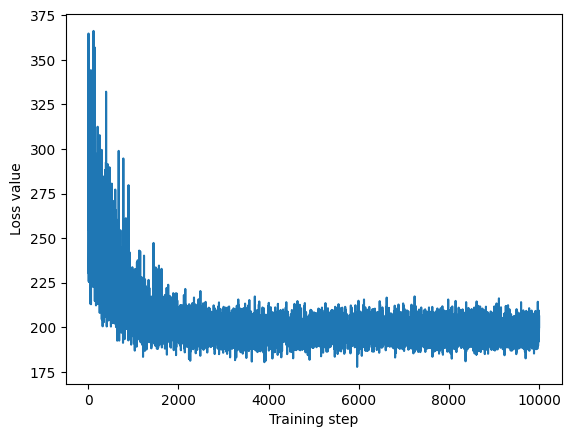

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
iaf_loss = tfp.vi.fit_surrogate_posterior(
    target_model_switch.unnormalized_log_prob,
    iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=4,
    jit_compile=True
)

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model_switch.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples)
)
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

## Analysis 1

In [ ]:
def plot_latent_variable_samples(switch_point_samples, early_rate_samples, late_rate_samples):
    for title, values in [
        ('Switch point posterior samples', switch_point_samples),
        ('Early disaster rate posterior samples', early_rate_samples),
        ('Late disaster rate posterior samples', late_rate_samples),
    ]:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
        sns.histplot(x=values, bins=50, ax=ax)
        ax.axvline(x=np.percentile(values, 50), color='k')
        ax.axvline(x=np.percentile(values, 2.5), color='k', ls='dashed', alpha=.5)
        ax.axvline(x=np.percentile(values, 97.5), color='k', ls='dashed', alpha=.5)
        ax.set_title(title)
        plt.show()

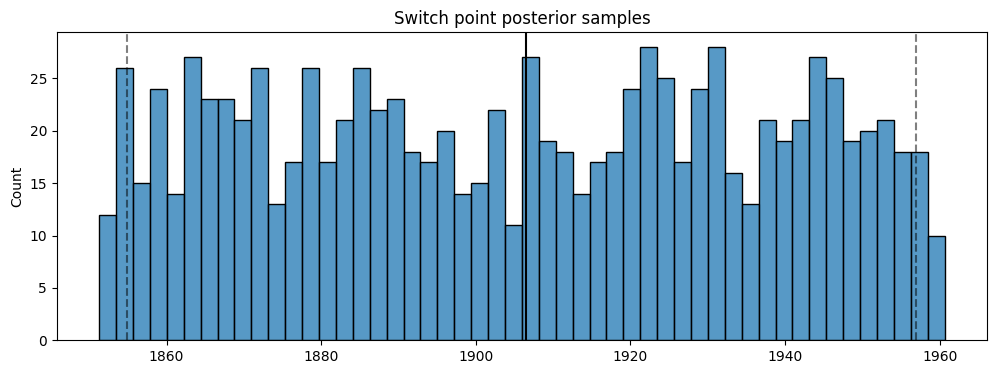

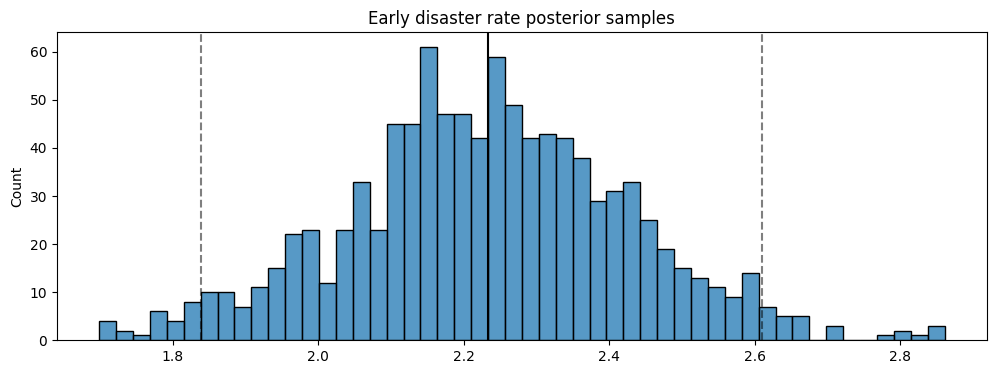

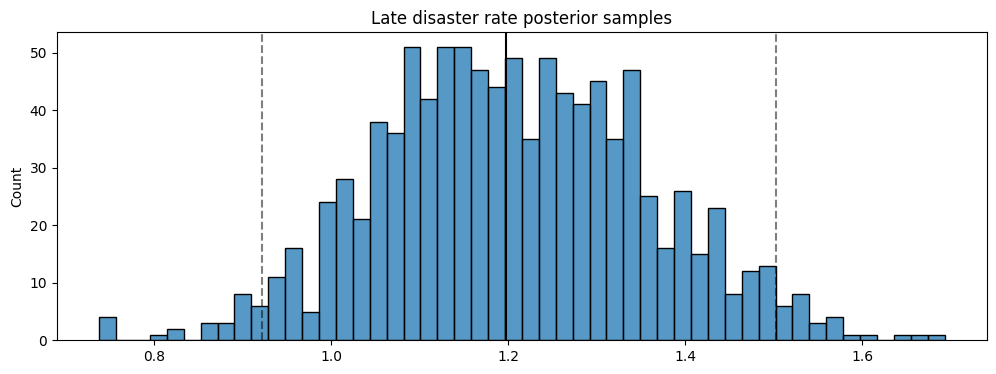

In [ ]:
plot_latent_variable_samples(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)

## Analysis 2

In [ ]:
def plot_rate_switch(switch_point_samples, early_rate_samples, late_rate_samples):
    rates = np.ones(years.shape) * np.mean(early_rate_samples)
    rates[years >= np.mean(switch_point_samples)] = np.mean(late_rate_samples)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
    ax.plot(years, disaster_data, 'o', markersize=8);
    ax.plot(years, rates, linewidth=3)
    ax.set_ylabel('Disaster count')
    ax.set_xlabel('Year')
    ax.set_title('Mining disaster data set')
    plt.show()

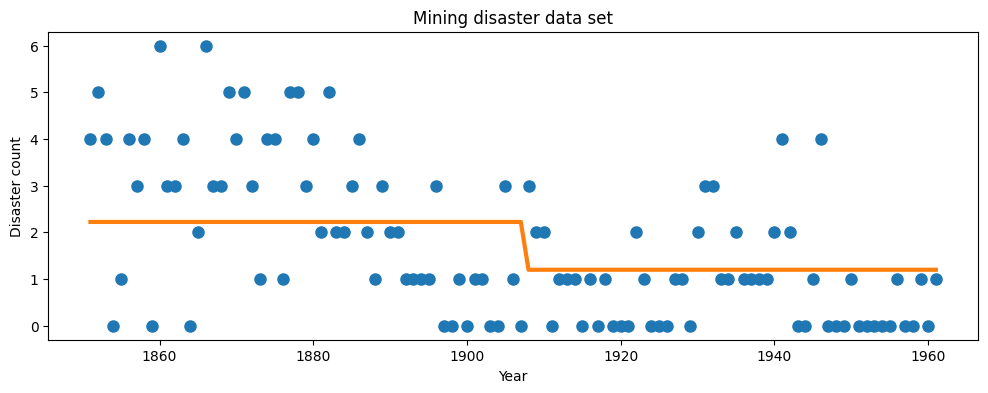

In [ ]:
plot_rate_switch(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)

In [ ]:
ess_vi = compute_ess(iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy())


print("Effective Sample Size (ESS):")
print(f"Variational Inference: Switchpoint: {ess_vi[0]}, Early Disaster Rate: {ess_vi[1]}, Late Disaster Rate: {ess_vi[2]}")



NameError: ignored

## Sigmoid Model

In [ ]:
event_shape = target_model_sigmoid.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this to constrain Normal samples to the prior's
# support.
event_space_bijector = target_model_sigmoid.experimental_default_event_space_bijector()

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
    tf.nest.pack_sequence_as(event_shape, range(len(flat_event_shape)))
)

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape)
)

In [ ]:
# Take a peek at the event shape and flat shape
# These are what the bijectors transform between
event_shape, flat_event_shape, flat_event_size

(StructTuple(
   early_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   late_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   switchpoint=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
 ),
 [<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>])

In [ ]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)]
)

# Apply an Inverted Autoregressive Flow to the base distribution.
# This is a neural network that learns to shift, scale and non-linearly-transform
# a probability distribution.
num_iafs = 2
hidden_size = 32
num_hidden_layers = 2
iaf_bijectors = [
    tfb.Invert(
        tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2,
                hidden_units=[hidden_size]*num_hidden_layers,
                activation='relu'
            )
        )
    )
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
        event_space_bijector,  # constrain the surrogate to the support of the prior
        unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
        reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
        split] +  # Split the samples into components of the same size as the prior components
        iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
    )
)

IAF surrogate posterior ELBO: -176.09719848632812


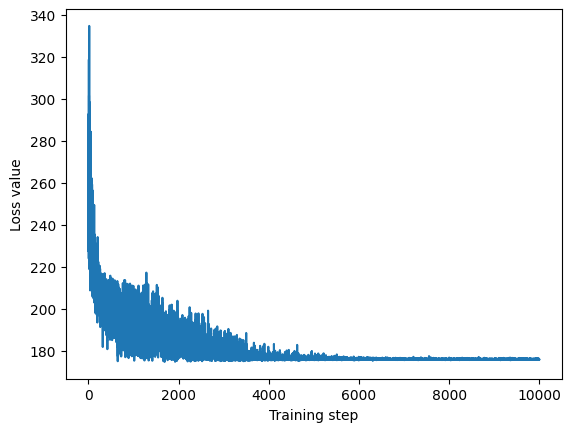

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
iaf_loss = tfp.vi.fit_surrogate_posterior(
    target_model_sigmoid.unnormalized_log_prob,
    iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=4,
    jit_compile=True
)

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model_sigmoid.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples)
)
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

## Analysis Sigmoid 1

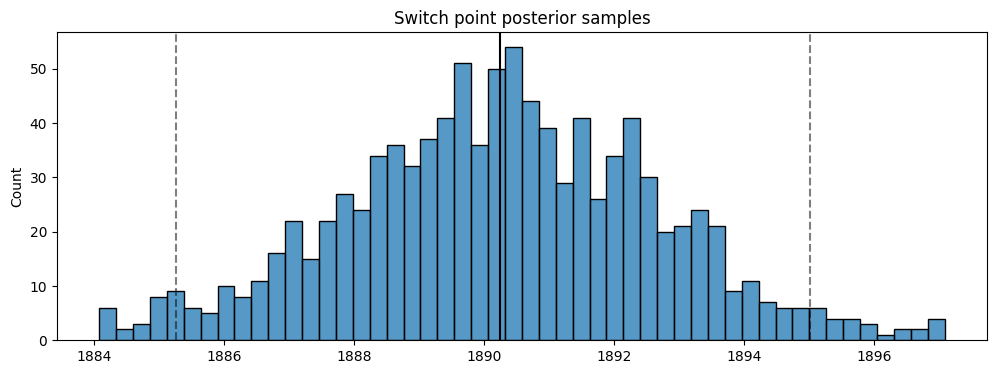

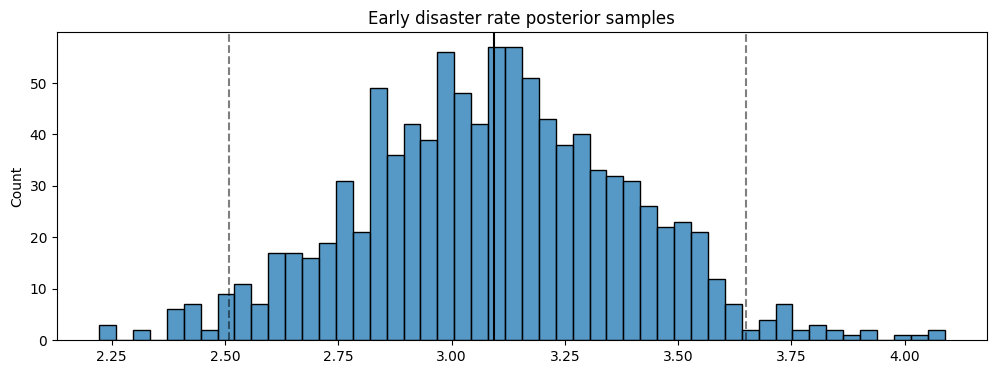

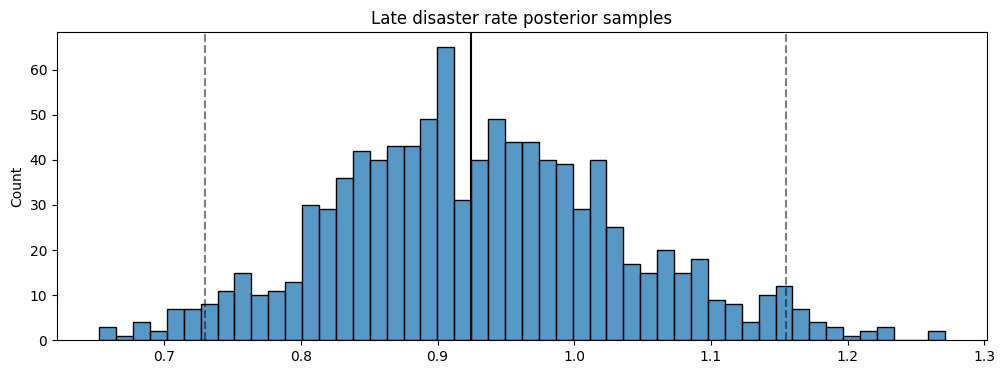

In [ ]:
plot_latent_variable_samples(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)

## Abakysis 2 Simoid 

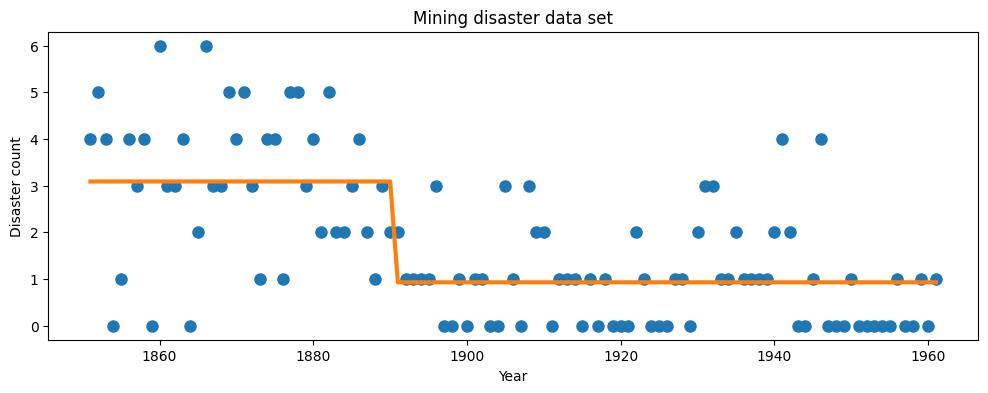

In [ ]:
plot_rate_switch(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)

In [ ]:
ess_vi_sigmoid = compute_ess(iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy())


print("Effective Sample Size (ESS):")
print(f"Variational Inference: Switchpoint: {ess_vi_sigmoid[0]}, Early Disaster Rate: {ess_vi_sigmoid[1]}, Late Disaster Rate: {ess_vi_sigmoid[2]}")


Effective Sample Size (ESS):
Variational Inference: Switchpoint: 934.0184326171875, Early Disaster Rate: 993.4683227539062, Late Disaster Rate: 969.2835083007812


# Approximate Bayesian Computation

In [ ]:
# Model
def disaster_rate_switch(ys, s, l, e):
    return np.where(ys < s, e, l)

def simulate_data(early_rate, late_rate, switchpoint, years):
    rates = disaster_rate_switch(years, switchpoint, late_rate, early_rate)
    return np.random.poisson(rates)

def euclidean_distance(simulated_data, observed_data):
    return np.sqrt(np.sum((simulated_data - observed_data)**2))

# Approximate Bayesian Computation
def abc(observed_data, years, n_samples, threshold):
    samples = []
    while len(samples) < n_samples:
        early_rate = np.random.exponential(1)
        late_rate = np.random.exponential(1)
        switchpoint = np.random.uniform(0, len(years))
        
        simulated_data = simulate_data(early_rate, late_rate, switchpoint, years)
        distance = euclidean_distance(simulated_data, observed_data)
        
        if distance < threshold:
            samples.append((early_rate, late_rate, switchpoint))
    
    return np.array(samples)

n_samples = 1000
threshold = 50
samples = abc(disaster_data, years, n_samples, threshold)


print(samples)

[[  1.36958228   0.70448944  98.2167105 ]
 [  1.02192272   0.83508289  24.76997767]
 [  1.39978031   1.25624589  35.74091881]
 ...
 [  0.45726692   3.36153689 104.33977475]
 [  0.80594574   3.23603453  93.92424604]
 [  0.41838127   0.50423225  41.3163325 ]]


In [ ]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early disaster rate ($e$) posterior samples', early_disaster_rate),
    ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
    ('Switch point ($s$) posterior samples', years[0] + switchpoint),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()

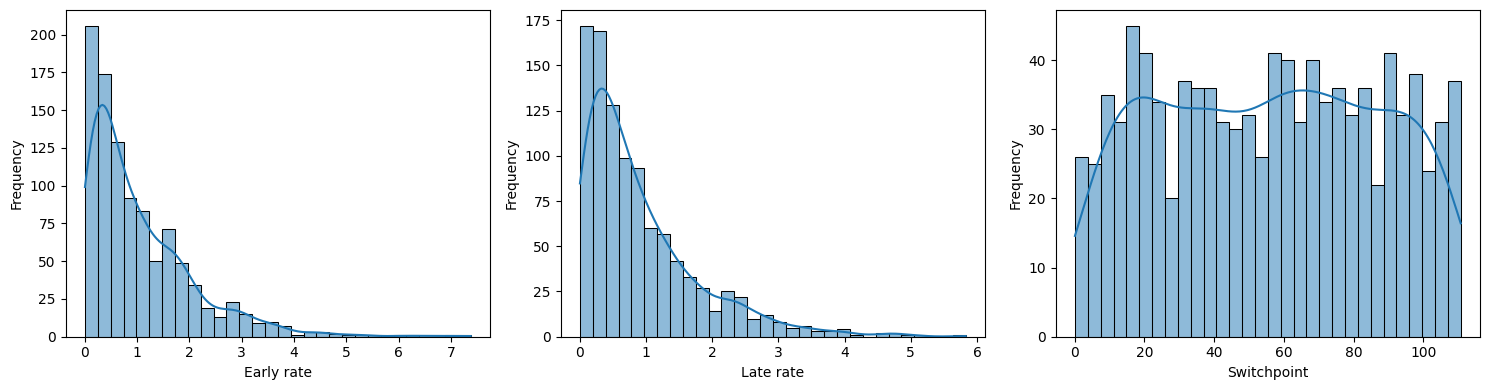

In [ ]:
# Visualization of the posterior distributions
import seaborn as sns

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

sns.histplot(samples[:, 0], ax=axes[0], kde=True, bins=30)
axes[0].set_xlabel("Early rate")
axes[0].set_ylabel("Frequency")

sns.histplot(samples[:, 1], ax=axes[1], kde=True, bins=30)
axes[1].set_xlabel("Late rate")
axes[1].set_ylabel("Frequency")

sns.histplot(samples[:, 2], ax=axes[2], kde=True, bins=30)
axes[2].set_xlabel("Switchpoint")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()